In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(15)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.66:47766 Dashboard: http://10.148.1.66:8787/status,Cluster Workers: 15 Cores: 420 Memory: 1.80 TB


_________
# 1. Read dataset


In [5]:
out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_work+'W_total_rechunk.zarr')
ds_D = xr.open_zarr(out_dir_work+'Pden_total_rechunk.zarr')
ds_KPP = xr.open_zarr(out_dir_work+'KPPhbl_total_rechunk.zarr')

# buoyancy
ds_B = -9.81*(ds_D.Pden-25)/1025
ds_B = np.real(ds_B).rename('Buoy')
ds_B = ds_B.to_dataset()

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_D,ds_KPP,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 .

# 2. Filter

## low-pass filter over 1 day

In [6]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

In [7]:
lowcut = 1/24/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq

b, a = butter(4, low, 'low')

In [8]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon_g': 1, 'depth':52}
U = ds.U.chunk(chunks)
del U.depth.encoding['chunks']

# filter
U_filter = butter_filter(U, b, a)
U_low_filter = np.real(U_filter).rename('U_low_filter')
U_low_filter = U_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 9415, 'lat': 201, 'lon_g': 177, 'depth':1}
U_low_filter = U_low_filter.chunk(chunks)

# save
file_out = out_dir_zarr+'/U_lowpass_filter_1day_rechunk.zarr'
%time U_low_filter.to_zarr(file_out, mode='w')   

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/worker.py:3221: UserWarning: Large object of size 2.09 MB detected in task graph: 
  ([["('xarray-dxC-65762be8954def1c907d7d2ab6f97a7b' ...  200, 176)"]],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


CPU times: user 1min 59s, sys: 5.61 s, total: 2min 5s
Wall time: 5min 16s


In [9]:
# rechunk data first
chunks = {'time': 9415, 'lat_g': 1, 'lon': 1, 'depth':52}
V = ds.V.chunk(chunks)
del V.depth.encoding['chunks']

# filter
V_filter = butter_filter(V, b, a)
V_low_filter = np.real(V_filter).rename('V_low_filter')
V_low_filter = V_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 9415, 'lat_g': 201, 'lon': 177, 'depth':1}
V_low_filter = V_low_filter.chunk(chunks)

# save
file_out = out_dir_zarr+'/V_lowpass_filter_1day_rechunk.zarr'
%time V_low_filter.to_zarr(file_out, mode='w')   

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 2min 21s, sys: 4.81 s, total: 2min 26s
Wall time: 5min 12s


In [10]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon': 1, 'depth':52}
W = ds.W.chunk(chunks)
del W.depth.encoding['chunks']

# filter
W_filter = butter_filter(W, b, a)
W_low_filter = np.real(W_filter).rename('W_low_filter')
W_low_filter = W_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
W_low_filter = W_low_filter.chunk(chunks)

# save
file_out = out_dir_zarr+'/W_lowpass_filter_rechunk.zarr'
%time W_low_filter.to_zarr(file_out, mode='w')   

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 3min 30s, sys: 5.38 s, total: 3min 35s
Wall time: 5min 43s


In [8]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon': 1, 'depth':52}
B = ds.Buoy.chunk(chunks)
del B.depth.encoding['chunks']

# filter
B_filter = butter_filter(B, b, a)
B_low_filter = np.real(B_filter).rename('B_low_filter')
B_low_filter = B_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
B_low_filter = B_low_filter.chunk(chunks)

# save
file_out = out_dir_zarr+'/B_lowpass_filter_rechunk.zarr'
%time B_low_filter.to_zarr(file_out, mode='w')   

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/worker.py:3221: UserWarning: Large object of size 2.06 MB detected in task graph: 
  ([["('xarray-rA-8af3e0cb162c00760963d7b8ce4a466f', ...  200, 176)"]],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)
Worker tcp://10.148.0.216:56345 restart in Job 7147623. This can be due to memory issue.


CPU times: user 2min 50s, sys: 6.81 s, total: 2min 57s
Wall time: 5min 20s


# 3. read filtered data

In [10]:
grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)

ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_filter_1day_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_filter_1day_rechunk.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_lowpass_filter_1day_rechunk.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_zarr+'B_lowpass_filter_1day_rechunk.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])
print(ds_filter)

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
    dxC           (lat, lon_g) float32 1567.638 1567.638 ... 1489.2013 1489.2013
    dyG           (lat, lon_g) float32 1468.5818 1468.5818 ... 1403.369 1403.369
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAw           (lat, lon_g) float32 2302204.5 2302204.5 ... 2089899.0
  * time          (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
    dxG           (lat_g, lon) float32 1567.8346 1567.8346 ... 1489.3967
    dyC           (lat_g, lon) float32 1468.746 1468.746 ... 1403.5306 1403.5306
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    rAs           (lat_g, 

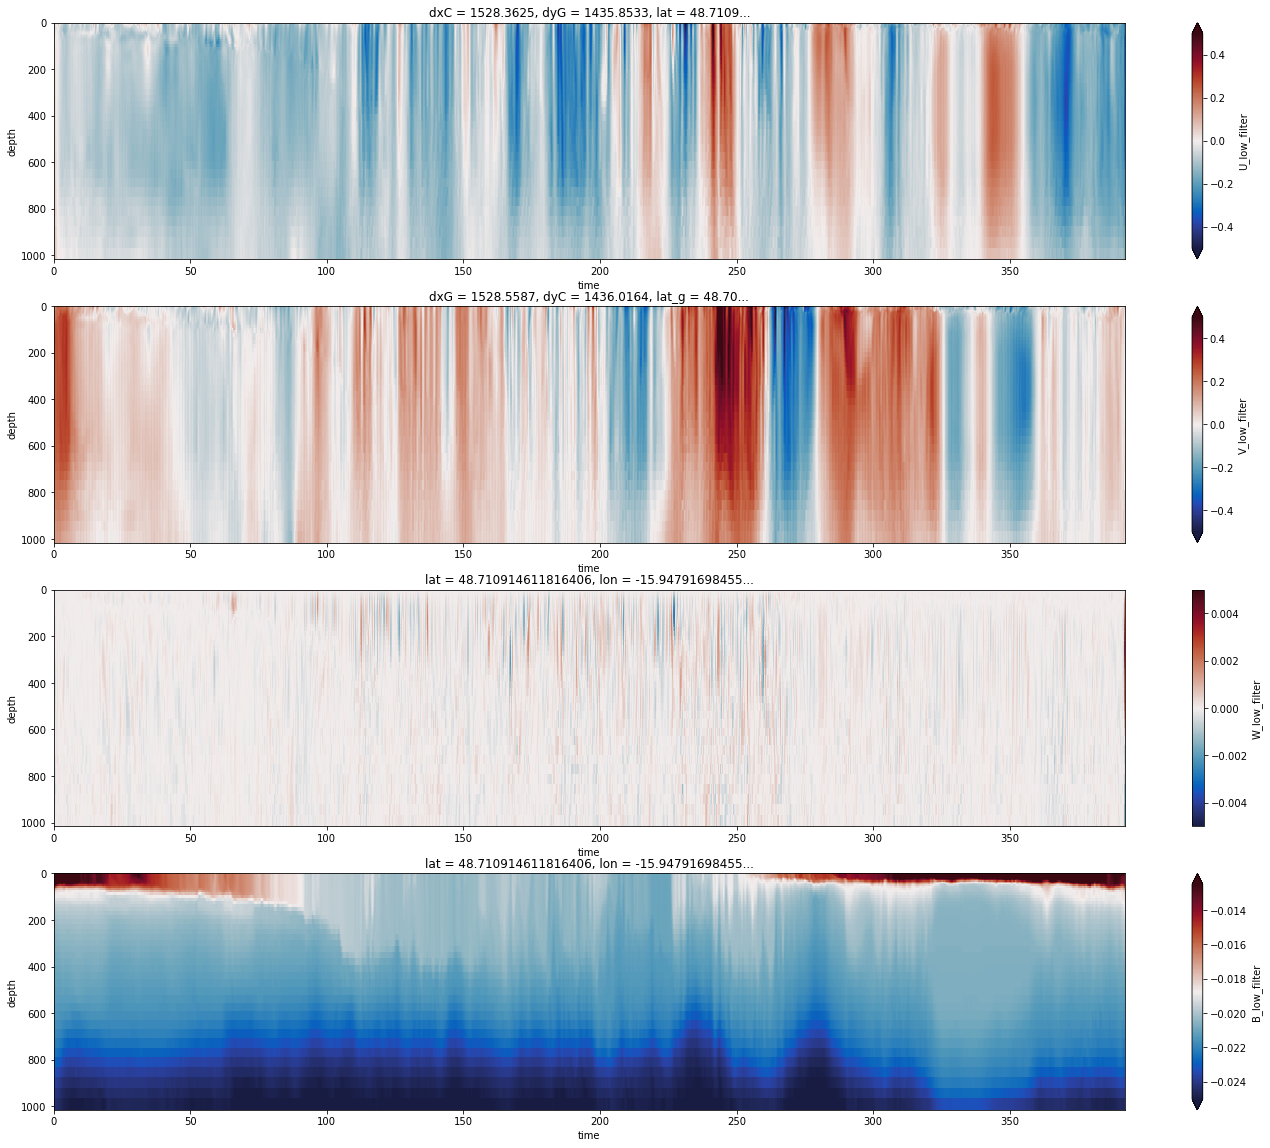

In [20]:
fig = plt.figure(figsize=(24,20))

plt.subplot(411)
ds_filter.U_low_filter.isel(lat=100,lon_g=100).plot(x='time', y='depth',vmin=-0.5,vmax=0.5,cmap=cm.balance, yincrease=False)

plt.subplot(412)
ds_filter.V_low_filter.isel(lat_g=100,lon=100).plot(x='time', y='depth',vmin=-0.5,vmax=0.5,cmap=cm.balance, yincrease=False)

plt.subplot(413)
ds_filter.W_low_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.005,vmax=0.005,cmap=cm.balance, yincrease=False)

plt.subplot(414)
ds_filter.B_low_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.025,vmax=-0.0125,cmap=cm.balance, yincrease=False)

In [12]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1